# Plot catalogue properties

Copied from `test_photoz.ipybn`.

Produce plots for the paper, and other stuff.

In [8]:
from functions import *
import params
import os

## Set up paths and parameters

In [9]:
path = os.getcwd() + '/'
bands = params.bands
output_path = params.output_path
output_name = params.output_name
temp_path = params.temp_path

spectral_path = params.spectral_path
spectral_names = params.spectral_names
path_to_tile_run = params.path_to_tile_run
spectral_surveys = params.spectral_surveys
vignet = params.vignet
    

cat = MakeCatalogs('ps3pi_cfis', bands, temp_path, output_name, output_path)

## Read input catalogue(s)

In [10]:
df_matched = pd.read_csv('CFIS_matched_deep_2_3_catalog_R_preprocessed.csv')
df_matched = df_matched.dropna()

In [11]:
df_unmatched = pd.read_csv('MediumDeep_IZG_CFHT_U_CFIS_R_catalog_unmatched.csv')

## Weights

Account for the difference in numbers between matched and unmatched catalogue, by introducing weights.
Here, this difference is only considered in the $r$-band magnitude number density. The weight is the ratio
of objects between the full (unmatched) and matched catalogues.

### Compute weights`

In [12]:
# Number of bins
n = 100

# band
column = 'r'

# density (histogram) of full (unmatched) catalogue
udensity, ubins_edge = np.histogram(df_unmatched[column].values, bins=n, density=True)
ubin_min = ubins_edge[0]
ubin_max = ubins_edge[-1]
ustep = (ubin_max - ubin_min)/n

# density (histogram) of matched catalogue
density, bins_edge = np.histogram(df_matched[column].values, bins=n, density=True)
bin_min = bins_edge[0]
bin_max = bins_edge[-1]
step = (bin_max - bin_min)/n

ID = np.arange(0, len(df_matched))
df_matched.insert(loc=0, value=ID, column='ID')
df_matched.sort_values(by=column, inplace=True)

weights, uweights = [], []
n_min = 0
n_umin = 0
h1, h2 = [], []
for i in range(len(df_matched)):
    for k in range(n_min, n):
        if bin_min+step*(k+1) < df_matched[column].values[i]:
            continue
        else:
            weights.append(density[k])
            n_min = k
            h1.append(df_matched[column].values[i])
            break 
        
    for k in range(n_umin, n):
        if ubin_min+ustep*(k+1) < df_matched[column].values[i]:
            continue
        else:
            uweights.append(udensity[k])
            n_umin = k
            h2.append(df_matched[column].values[i])
        
        break 
  
# Final weight = ratio of densities
w = np.array(uweights) / np.array(weights)

### Plot number densities and corresponding weight

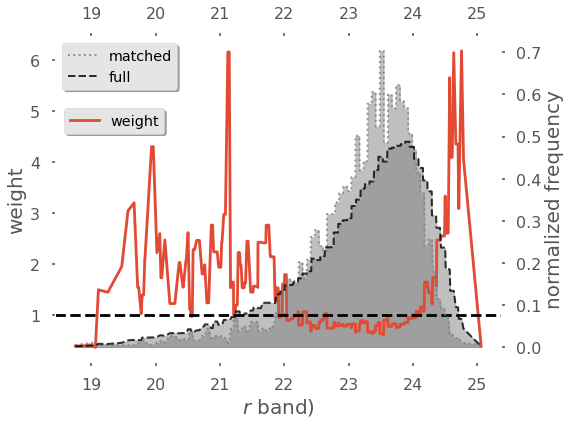

In [13]:
fontsize = 20
linewidth = 2

fig = plt.figure(figsize=(8, 6), tight_layout=False, frameon=True)

ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
ax3 = ax2.twiny()
ax1.get_shared_x_axes().join(ax2, ax3)
ax2.grid(False)
ax3.grid(False)
ax2.set_ylabel('normalized frequency', fontsize=fontsize)

ax1.set_facecolor('white')
#ax1.grid(True, color='grey', lw=0.5)
ax1.grid(False)
ax1.set_xlabel(r'$r$' + ' band)', fontsize=fontsize)
ax1.set_ylabel('weight', fontsize=fontsize)

ax1.plot(df_matched[column].to_numpy(), w, label='weight')
ax1.axhline(1, color='k', linestyle='--')

ax2.plot(h1, np.array(weights), linestyle='dotted', linewidth=linewidth, color='grey', alpha=0.8, label='matched')
ax3.fill_between(h1, np.array(weights), color='grey', alpha=0.5)

ax2.plot(h2, np.array(uweights), linestyle='dashed', linewidth=linewidth, color='k', alpha=0.8, label='full')
ax3.fill_between(h2, np.array(uweights), color='grey', alpha=0.5)

legend = ax2.legend(loc='upper left', shadow=True, fontsize='x-large')
legend = ax1.legend(loc=(0.02,0.7), shadow=True, fontsize='x-large')

# order
ax3.zorder = 1 # fills in back
ax1.zorder = 2 # then the line
ax2.zorder = 3 # then the points
ax1.patch.set_visible(False)

plt.savefig('mag_weight_dist_deep23.pdf', bbox_inches='tight', transparent=True)
plt.show()

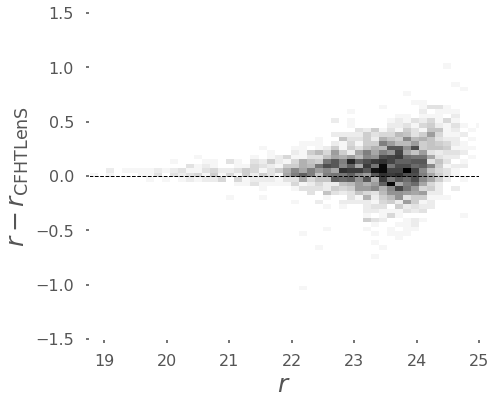

In [43]:
CFHT_CFIS = pd.read_csv('R_CFHT_vs_CFIS.csv')
CFHT_CFIS = CFHT_CFIS.dropna()

MAG_r = CFHT_CFIS['MAG_r'].values
MAG_AUTO_R = CFHT_CFIS['MAG_AUTO_R'].values

lim = 1.5

fig =plt.figure(figsize=(7,6), tight_layout=False)

ax = fig.add_subplot(111)
ax.set_facecolor('white')
ax.grid(True, color='grey', lw=0.5)
ax.set_ylabel('$r - r_\\mathrm{{CFHTLenS}}$', size=25)
ax.set_xlabel('$r$', size=25)
dr = MAG_r - MAG_AUTO_R

im = ax.hist2d(MAG_r, dr, bins=(50, 50), cmap='gist_yarg')
ax.set_xlim([np.amin(MAG_AUTO_R), 25])
ax.set_ylim([-1.5, 1.5])

#cbar = fig.colorbar(im[3])


x = np.linspace(0, 25, 1000)
ax.plot([0, 25], [0, 0], linewidth=1, color='k', linestyle='--')
#ax.set_aspect('equal', 'box')


plt.savefig('R_CFHT_vs_R_CFIS.pdf', bbox_inches='tight', transparent=True)
plt.show()

In [ ]:
df_matched = pd.read_csv('output/' + 'ps3pi_cfis' + '/CFIS_matched_deep_2_3_catalog_R' + '/files/' + 'CFIS_matched_deep_2_3_catalog_R_preprocessed' + '.csv')
df_matched = df_matched.dropna()
X_train, X_test, y_train, y_test, weights_train, _ = train_test_split(df_matched.iloc[:,:-1], df_matched.iloc[:,-1], weights, test_size = 0.2, random_state=0)
df_matched.head(10)

In [ ]:
regressor = RandomForestRegressor()
regressor.fit(X_train, y_train, sample_weight=weights_train)
y_pred = regressor.predict(X_test)
plt.figure(figsize=(6,5))
plt.hist2d(y_test, y_pred, bins=(50,50))
plt.colorbar()
plt.show()

In [ ]:
weights = cat.compute_weights(df_matched, column = 'MAG_AUTO_R')

In [ ]:
ML = LearningAlgorithms(survey = 'ps3pi_cfis', bands = bands, dataframe= df_matched, output_name = output_name, output_path=output_path, sample_weight=weights, n_jobs=1)
                
weight_train = ML.weight_train()
print(weight_train)